In [37]:
import pandas as pd
import scanpy as sc
import anndata as ad
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.sparse as sps

import os
# os.environ['R_HOME'] = "/Library/Frameworks/R.framework/Resources"
# import pertpy as pt
    
import tools.util_probe as up
import tools.util as ut
import tools.NB_est as nb
import tools.countsplit as cs
import tools.scDEED as scd
import tools.clustering_opt as co
import tools.scTransform as sct

import warnings
warnings.filterwarnings("ignore")

In [2]:
import importlib

## Preprocessing
### Read data

In [3]:
data_path = "../../data/filtered_gene_bc_matrices/hg19"
data_all = sc.read(data_path + "/pbmc.h5ad")
data_all

AnnData object with n_obs × n_vars = 2700 × 32738
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA'
    layers: 'counts'

### Aggregate probes through max-pooling

In [4]:
print(f"Zero inflation of probe-wise data: {((np.prod(data_all.X.shape) - data_all.X.getnnz()) / np.prod(data_all.X.shape)).round(3)}")


Zero inflation of probe-wise data: 0.974


### Filter cells

--> filter based on mean absolute standard deviation

In [103]:
sc.pp.calculate_qc_metrics(data_all, var_type="genes", percent_top=None, log1p=True, inplace=True)

data_gene = data_all.copy()
sc.pp.filter_genes(data_gene, min_cells=3)
sc.pp.filter_cells(data_gene, min_counts=200)
sc.pp.filter_cells(data_gene, max_counts=5000)
sc.pp.calculate_qc_metrics(data_gene, var_type="genes", percent_top=None, log1p=True, inplace=True)

print(f"Initial number of cells: {data_all.n_obs}")
print(f"Number of cells after filtering: {data_gene.n_obs}")
data_gene

Initial number of cells: 2700
Number of cells after filtering: 2631


AnnData object with n_obs × n_vars = 2631 × 13714
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'n_counts'
    var: 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells'
    layers: 'counts'

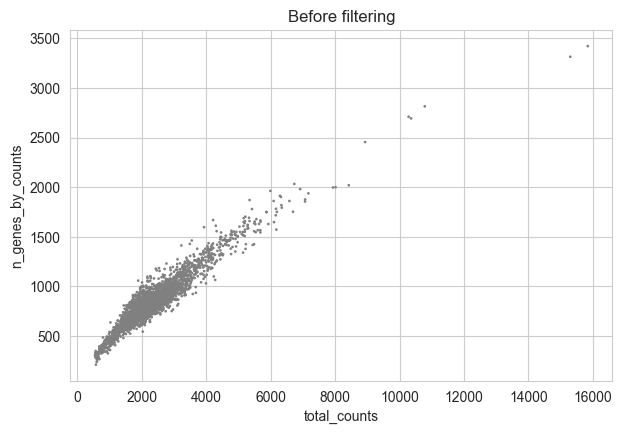

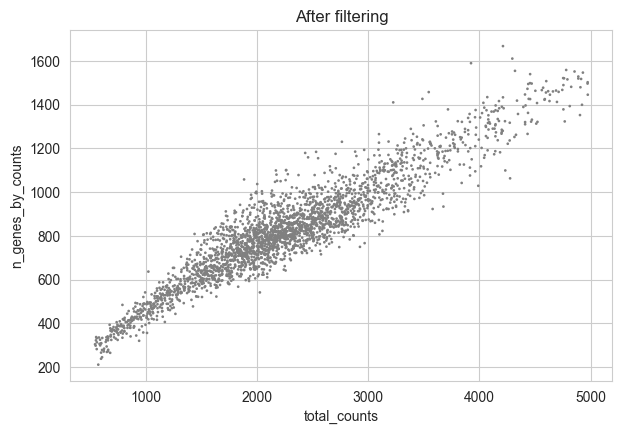

In [104]:
sc.pl.scatter(data_all, x='total_counts', y='n_genes_by_counts', show=False, size=15, title="Before filtering")
plt.show()
sc.pl.scatter(data_gene, x='total_counts', y='n_genes_by_counts', show=False, size=15, title="After filtering")
plt.show()

## Variance stabilization

Plotting the mean-variance ratio of genes, we see that the data is clearly overdispersed. Therefore, we will use negative binomial count splitting

In [105]:
data_gene.layers["counts"] = data_gene.X.copy()

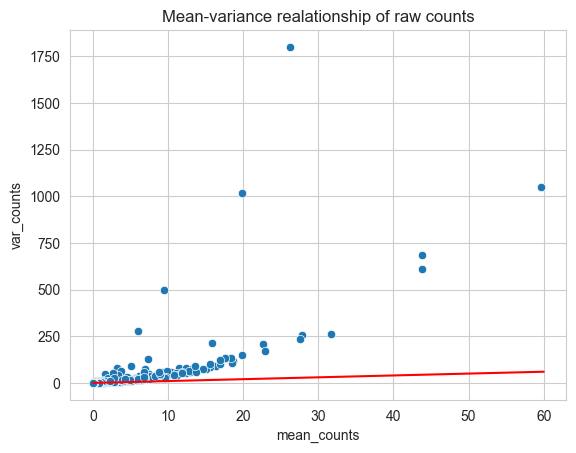

In [106]:
data_gene.var["var_counts"] = np.asarray(np.var(data_gene.X.toarray(), axis=0)).squeeze()
data_gene.var["mean_counts"] = np.asarray(np.mean(data_gene.X.toarray(), axis=0)).squeeze()
sns.scatterplot(data=data_gene.var, x="mean_counts", y="var_counts")
plt.plot([0, np.ceil(np.max(data_gene.var["mean_counts"]))], [0, np.ceil(np.max(data_gene.var["mean_counts"]))], color="red")
plt.title("Mean-variance realationship of raw counts")
plt.show()

## Estimate negative binomial parameters for each gene

In [107]:
adata_sct = sct.SCTransform(data_gene,
                        min_cells=1,
                        gmean_eps=1,
                        n_genes=2000,
                        n_cells=None, #use all cells
                        bin_size=500,
                        bw_adjust=3,
                        inplace=False)
data_gene.var["theta_sct"] = adata_sct.var["theta_sct"]
data_gene.var["theta_sct"][data_gene.var["theta_sct"] < 0.01] = 0.01
data_gene.var["theta_sct"][np.isnan(data_gene.var["theta_sct"])] = 0.01
data_gene.var["Intercept_sct"] = adata_sct.var["Intercept_sct"]


In [108]:
np.min(data_gene.var["theta_sct"])

0.01

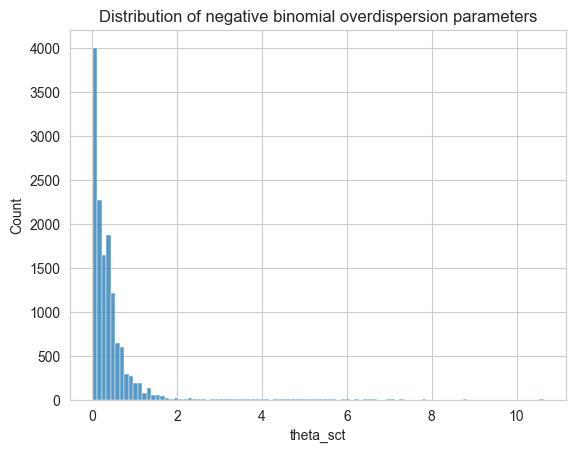

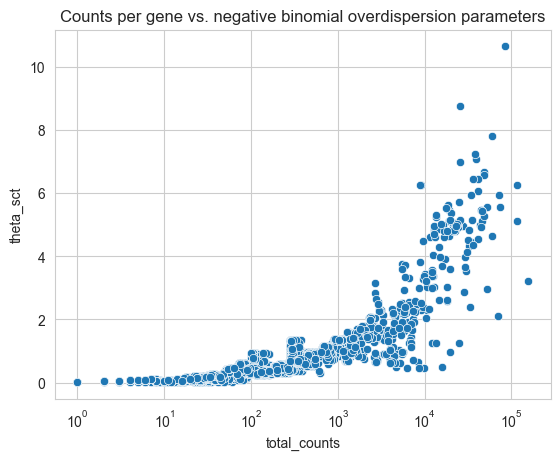

In [109]:
sns.histplot(data=data_gene.var, x="theta_sct", bins=100)
plt.title("Distribution of negative binomial overdispersion parameters")
plt.show()

g = sns.scatterplot(data=data_gene.var, y="theta_sct", x="total_counts")
g.set(xscale="log")
plt.title("Counts per gene vs. negative binomial overdispersion parameters")
plt.show()

In [110]:
print(data_gene.X)

  (0, 29)	1.0
  (0, 73)	1.0
  (0, 80)	2.0
  (0, 148)	1.0
  (0, 163)	1.0
  (0, 184)	1.0
  (0, 186)	1.0
  (0, 227)	41.0
  (0, 229)	1.0
  (0, 230)	1.0
  (0, 231)	1.0
  (0, 247)	1.0
  (0, 266)	2.0
  (0, 268)	6.0
  (0, 328)	1.0
  (0, 335)	1.0
  (0, 360)	1.0
  (0, 386)	1.0
  (0, 398)	1.0
  (0, 413)	1.0
  (0, 436)	2.0
  (0, 445)	1.0
  (0, 466)	15.0
  (0, 481)	1.0
  (0, 489)	1.0
  :	:
  (2630, 13352)	1.0
  (2630, 13355)	1.0
  (2630, 13367)	1.0
  (2630, 13393)	2.0
  (2630, 13406)	2.0
  (2630, 13436)	17.0
  (2630, 13450)	1.0
  (2630, 13452)	2.0
  (2630, 13458)	1.0
  (2630, 13463)	1.0
  (2630, 13464)	1.0
  (2630, 13477)	1.0
  (2630, 13526)	1.0
  (2630, 13530)	1.0
  (2630, 13567)	1.0
  (2630, 13602)	1.0
  (2630, 13635)	1.0
  (2630, 13648)	1.0
  (2630, 13671)	1.0
  (2630, 13696)	3.0
  (2630, 13697)	1.0
  (2630, 13698)	7.0
  (2630, 13702)	1.0
  (2630, 13705)	1.0
  (2630, 13708)	3.0


In [111]:
data_gene.X = data_gene.layers["counts"].copy()

## Normalization, VST, scaling and PCA

In [112]:
sc.pp.normalize_total(data_gene, target_sum=10000, layer=None)
print(type(data_gene.X))
sc.pp.log1p(data_gene)
print(type(data_gene.X))
data_gene.layers["vst_counts"] = data_gene.X.copy()
print(type(data_gene.X))
sc.pp.highly_variable_genes(data_gene, flavor="seurat_v3", n_top_genes=2000)
# data_gene = data_gene[:, data_gene.var.highly_variable]
sc.pp.scale(data_gene, max_value=10, zero_center=True)
sc.tl.pca(data_gene, svd_solver='arpack')

<class 'scipy.sparse._csr.csr_matrix'>
<class 'scipy.sparse._csr.csr_matrix'>
<class 'scipy.sparse._csr.csr_matrix'>


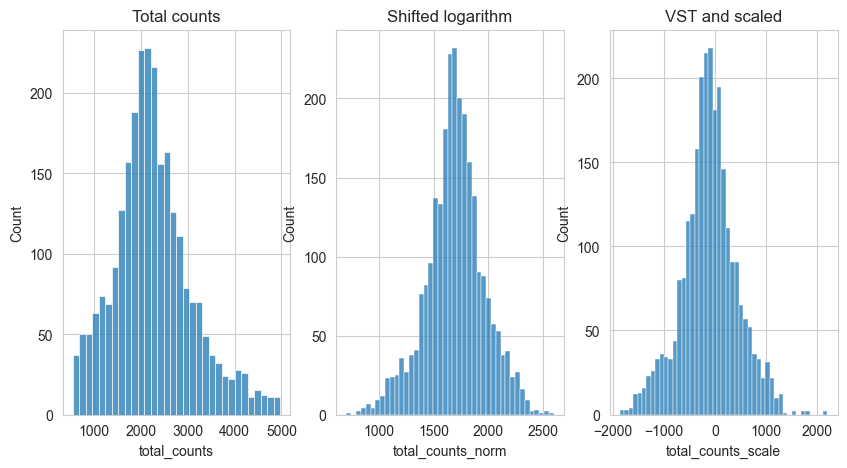

In [113]:
fig, axes = plt.subplots(1, 3, figsize=(10, 5))
p1 = sns.histplot(data_gene.obs, x="total_counts", kde=False, ax=axes[0], multiple="stack")
axes[0].set_title("Total counts")
data_gene.obs["total_counts_norm"] = data_gene.layers["vst_counts"].sum(1)
p2 = sns.histplot(data_gene.obs, x="total_counts_norm", kde=False, ax=axes[1], multiple="stack")
axes[1].set_title("Shifted logarithm")
data_gene.obs["total_counts_scale"] = data_gene.X.sum(1)
p2 = sns.histplot(data_gene.obs, x="total_counts_scale", kde=False, ax=axes[2], multiple="stack")
axes[2].set_title("VST and scaled")
plt.show()

## Count-splitting into train and test data

In [114]:
print(data_gene.var["theta_sct"][6988])

0.01


In [115]:
importlib.reload(cs)
data_train, data_test = cs.countsplit_adata(data_gene, data_dist="NB", beta_key="theta_sct", mean_key="Intercept_sct", layer="counts", min_cells=3, min_counts=200, max_counts=5000, seed=6)


In [116]:
data_train

AnnData object with n_obs × n_vars = 2631 × 12050
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'n_counts', 'total_counts_norm', 'total_counts_scale', 'n_genes', 'n_PCs_by_counts', 'log1p_n_PCs_by_counts'
    var: 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells', 'var_counts', 'theta_sct', 'Intercept_sct', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'mean', 'std', 'nb_mean', 'nb_overdisp'
    layers: 'counts'

In [117]:
# Transformation, centering and PCA
sc.pp.normalize_total(data_train, target_sum=10000, layer=None)
sc.pp.log1p(data_train)
data_train.layers["vst_counts"] = data_train.X.copy()
sc.pp.highly_variable_genes(data_train, flavor="seurat_v3", n_top_genes=2000)
data_train = data_train[:, data_train.var.highly_variable]
sc.pp.scale(data_train, max_value=10, zero_center=True)
sc.tl.pca(data_train, svd_solver='arpack')


sc.pp.normalize_total(data_test, target_sum=10000, layer=None)
sc.pp.log1p(data_test)
data_test.layers["vst_counts"] = data_test.X.copy()
data_test= data_test[:, data_train.var.index]
sc.pp.scale(data_test, max_value=10, zero_center=True)
sc.tl.pca(data_test, svd_solver='arpack')

In [118]:
print(data_train)
print(data_test)

AnnData object with n_obs × n_vars = 2631 × 2000
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'n_counts', 'total_counts_norm', 'total_counts_scale', 'n_genes', 'n_PCs_by_counts', 'log1p_n_PCs_by_counts'
    var: 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells', 'var_counts', 'theta_sct', 'Intercept_sct', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'mean', 'std', 'nb_mean', 'nb_overdisp'
    uns: 'log1p', 'hvg', 'pca'
    obsm: 'X_pca'
    varm: 'PCs'
    layers: 'counts', 'vst_counts'
AnnData object with n_obs × n_vars = 2631 × 2000
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'n_counts', 'total_counts_norm', 'total_counts_scale', 'n_genes', 'n_PCs_by_counts', 'log1p_n_PCs_by_counts'

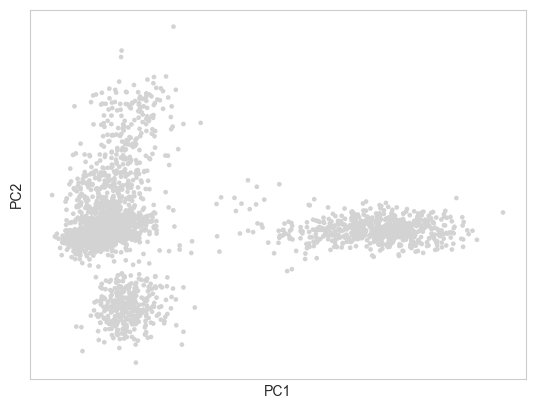

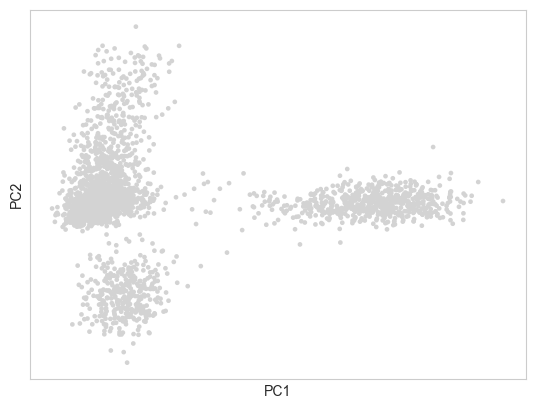

In [119]:
sc.pl.pca(data_train)
plt.show()

sc.pl.pca(data_test)
plt.show()

### Principal component selection

In [122]:
importlib.reload(cs)
k_errors, k_opt = cs.select_n_pcs_countsplit(data_train, data_test)
print(f"Optimal number of PCs:{k_opt}")

Optimal number of PCs:6


[2438315.278727624, 2410451.15694329, 2393397.6965067866, 2386881.287199718, 2378272.213823373, 2376843.0239525707, 2379055.7393244393, 2385097.3096265206, 2388894.7591541866, 2394611.7819130095, 2399416.4334394843, 2404623.0822177725, 2409701.890664285, 2414539.765847146, 2419983.0600606594, 2425359.3632878675, 2430543.275030812, 2435808.2677770415, 2440800.0630492507, 2445758.932773145]


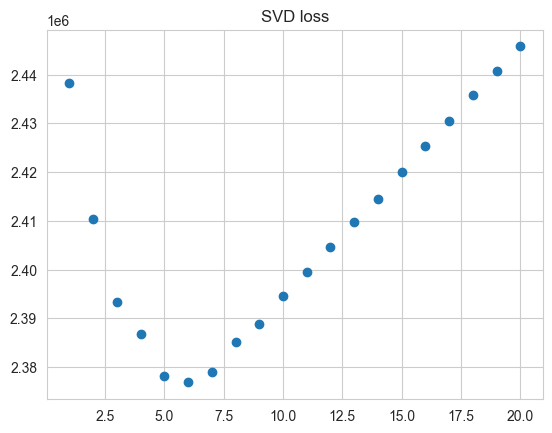

In [123]:
print(k_errors)
plt.scatter(np.arange(20) + 1, k_errors)
plt.title("SVD loss")
plt.show()

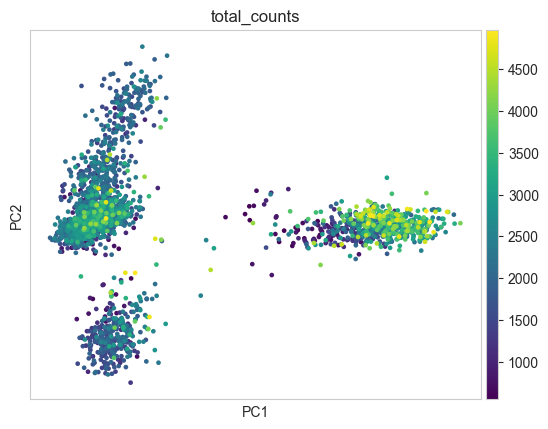

In [126]:
sc.pl.pca(data_gene, color="total_counts", cmap="viridis")
plt.show()

In [127]:
print(data_gene)

AnnData object with n_obs × n_vars = 2631 × 13714
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'n_counts', 'total_counts_norm', 'total_counts_scale'
    var: 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells', 'var_counts', 'theta_sct', 'Intercept_sct', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'mean', 'std'
    uns: 'log1p', 'hvg', 'pca'
    obsm: 'X_pca'
    varm: 'PCs'
    layers: 'counts', 'vst_counts'


## Selection of optimal number of neighbors and optimal UMAP scale via scDEED

In [128]:
importlib.reload(scd)

n_neighborss = [10, 15, 20, 25, 30, 35, 40, 45, 50, 60, 70, 80, 90, 100]
min_dists = [0.05, 0.1, 0.3, 0.5]

scdeed_result, rel_scores, null_rel_scores, reliabilities, n_neighbors_opt, min_dist_opt = scd.scdeed_parameter_selection(data_gene, n_neighborss, min_dists, n_pcs=k_opt, embedding_method="UMAP", similarity_percent=0.5, save_path="S2_filtered_scdeed")

calculating (10, 0.05) - run 1/56
calculating (10, 0.1) - run 2/56
calculating (10, 0.3) - run 3/56
calculating (10, 0.5) - run 4/56
calculating (15, 0.05) - run 5/56
calculating (15, 0.1) - run 6/56
calculating (15, 0.3) - run 7/56
calculating (15, 0.5) - run 8/56
calculating (20, 0.05) - run 9/56
calculating (20, 0.1) - run 10/56
calculating (20, 0.3) - run 11/56
calculating (20, 0.5) - run 12/56
calculating (25, 0.05) - run 13/56
calculating (25, 0.1) - run 14/56
calculating (25, 0.3) - run 15/56
calculating (25, 0.5) - run 16/56
calculating (30, 0.05) - run 17/56
calculating (30, 0.1) - run 18/56
calculating (30, 0.3) - run 19/56
calculating (30, 0.5) - run 20/56
calculating (35, 0.05) - run 21/56
calculating (35, 0.1) - run 22/56
calculating (35, 0.3) - run 23/56
calculating (35, 0.5) - run 24/56
calculating (40, 0.05) - run 25/56
calculating (40, 0.1) - run 26/56
calculating (40, 0.3) - run 27/56
calculating (40, 0.5) - run 28/56
calculating (45, 0.05) - run 29/56
calculating (45

Optimal number of neighbors: 40
Optimal min_dist: 0.3


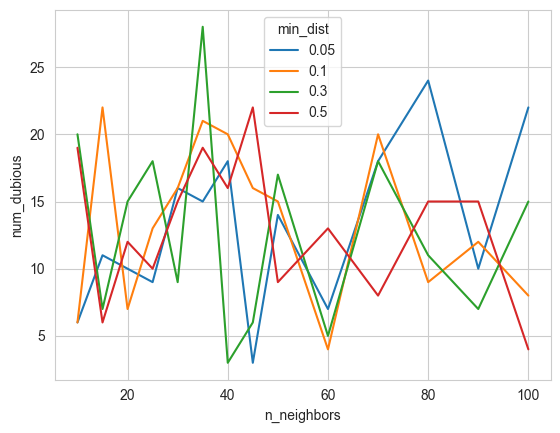

In [129]:
print(f"Optimal number of neighbors: {n_neighbors_opt}")
print(f"Optimal min_dist: {min_dist_opt}")

sns.lineplot(data=scdeed_result, x="n_neighbors", y="num_dubious", hue="min_dist", palette="tab10")
plt.show()

In [130]:
sc.pp.neighbors(data_gene, n_neighbors=n_neighbors_opt, n_pcs=k_opt)
sc.tl.umap(data_gene, neighbors_key="neighbors", min_dist=min_dist_opt, spread=1)


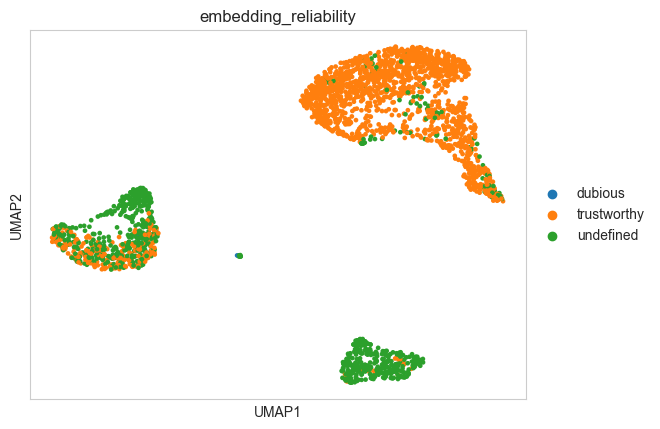

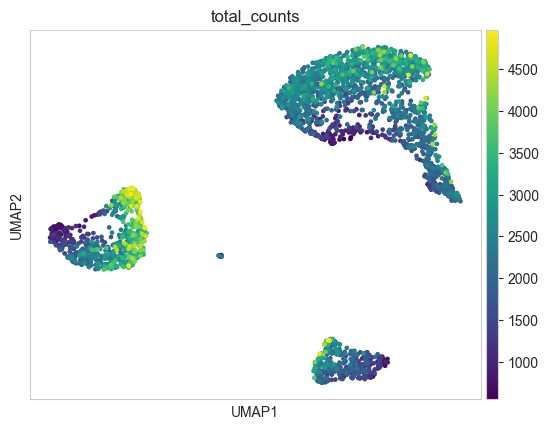

In [131]:
sc.pl.umap(data_gene, color="embedding_reliability", alpha=1)
plt.show()

sc.pl.umap(data_gene, color="total_counts", alpha=1, cmap="viridis")
plt.show()

In [132]:
data_gene.write(data_path + "/filtered_data_maxpool_processed.h5ad")


## Clustering

### Train/test-split for clustering

In [133]:
sc.pp.neighbors(data_train, n_neighbors=n_neighbors_opt, n_pcs=k_opt)
sc.tl.umap(data_train, neighbors_key="neighbors", min_dist=min_dist_opt, spread=1)

sc.pp.neighbors(data_test, n_neighbors=n_neighbors_opt, n_pcs=k_opt)
sc.tl.umap(data_test, neighbors_key="neighbors", min_dist=min_dist_opt, spread=1)

# Rotate test UMAP for better comparability
theta_opt, mirror_opt, umap_2_opt, ssd = ut.find_opt_umap_rotation(data_train.obsm["X_umap"].copy(), data_test.obsm["X_umap"].copy())
data_test.obsm["X_umap_rot"] = umap_2_opt

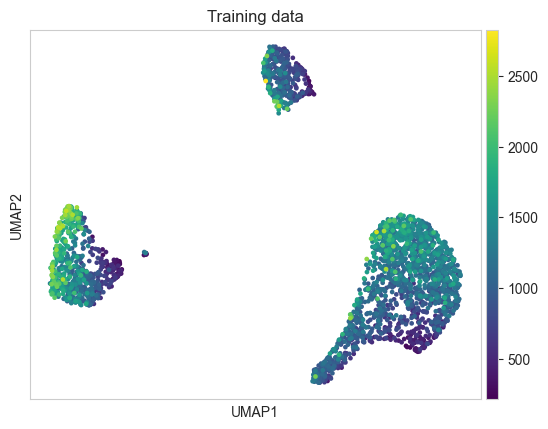

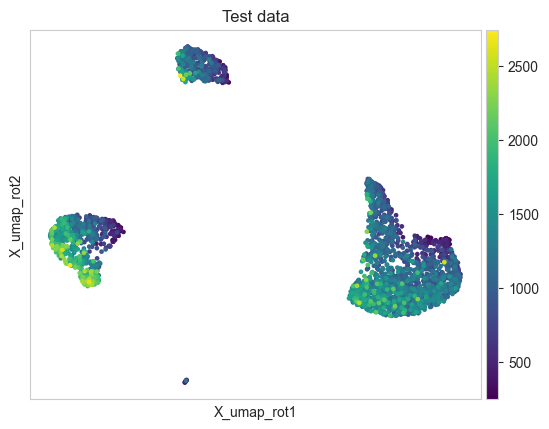

In [134]:
sc.pl.umap(data_train, color="total_counts", cmap="viridis", title="Training data")
plt.show()

sc.pl.embedding(data_test, basis="X_umap_rot", color="total_counts", cmap="viridis", title="Test data")
plt.show()

### Apply clustering with array of resolutions

In [135]:
importlib.reload(co)
res_min = 0.01
res_max = 0.5
res_step = 0.02
resolutions = np.round(np.arange(res_min, res_max, res_step), 2)

co.cluster_train_test(data_train, data_test, resolutions, alg="leiden")

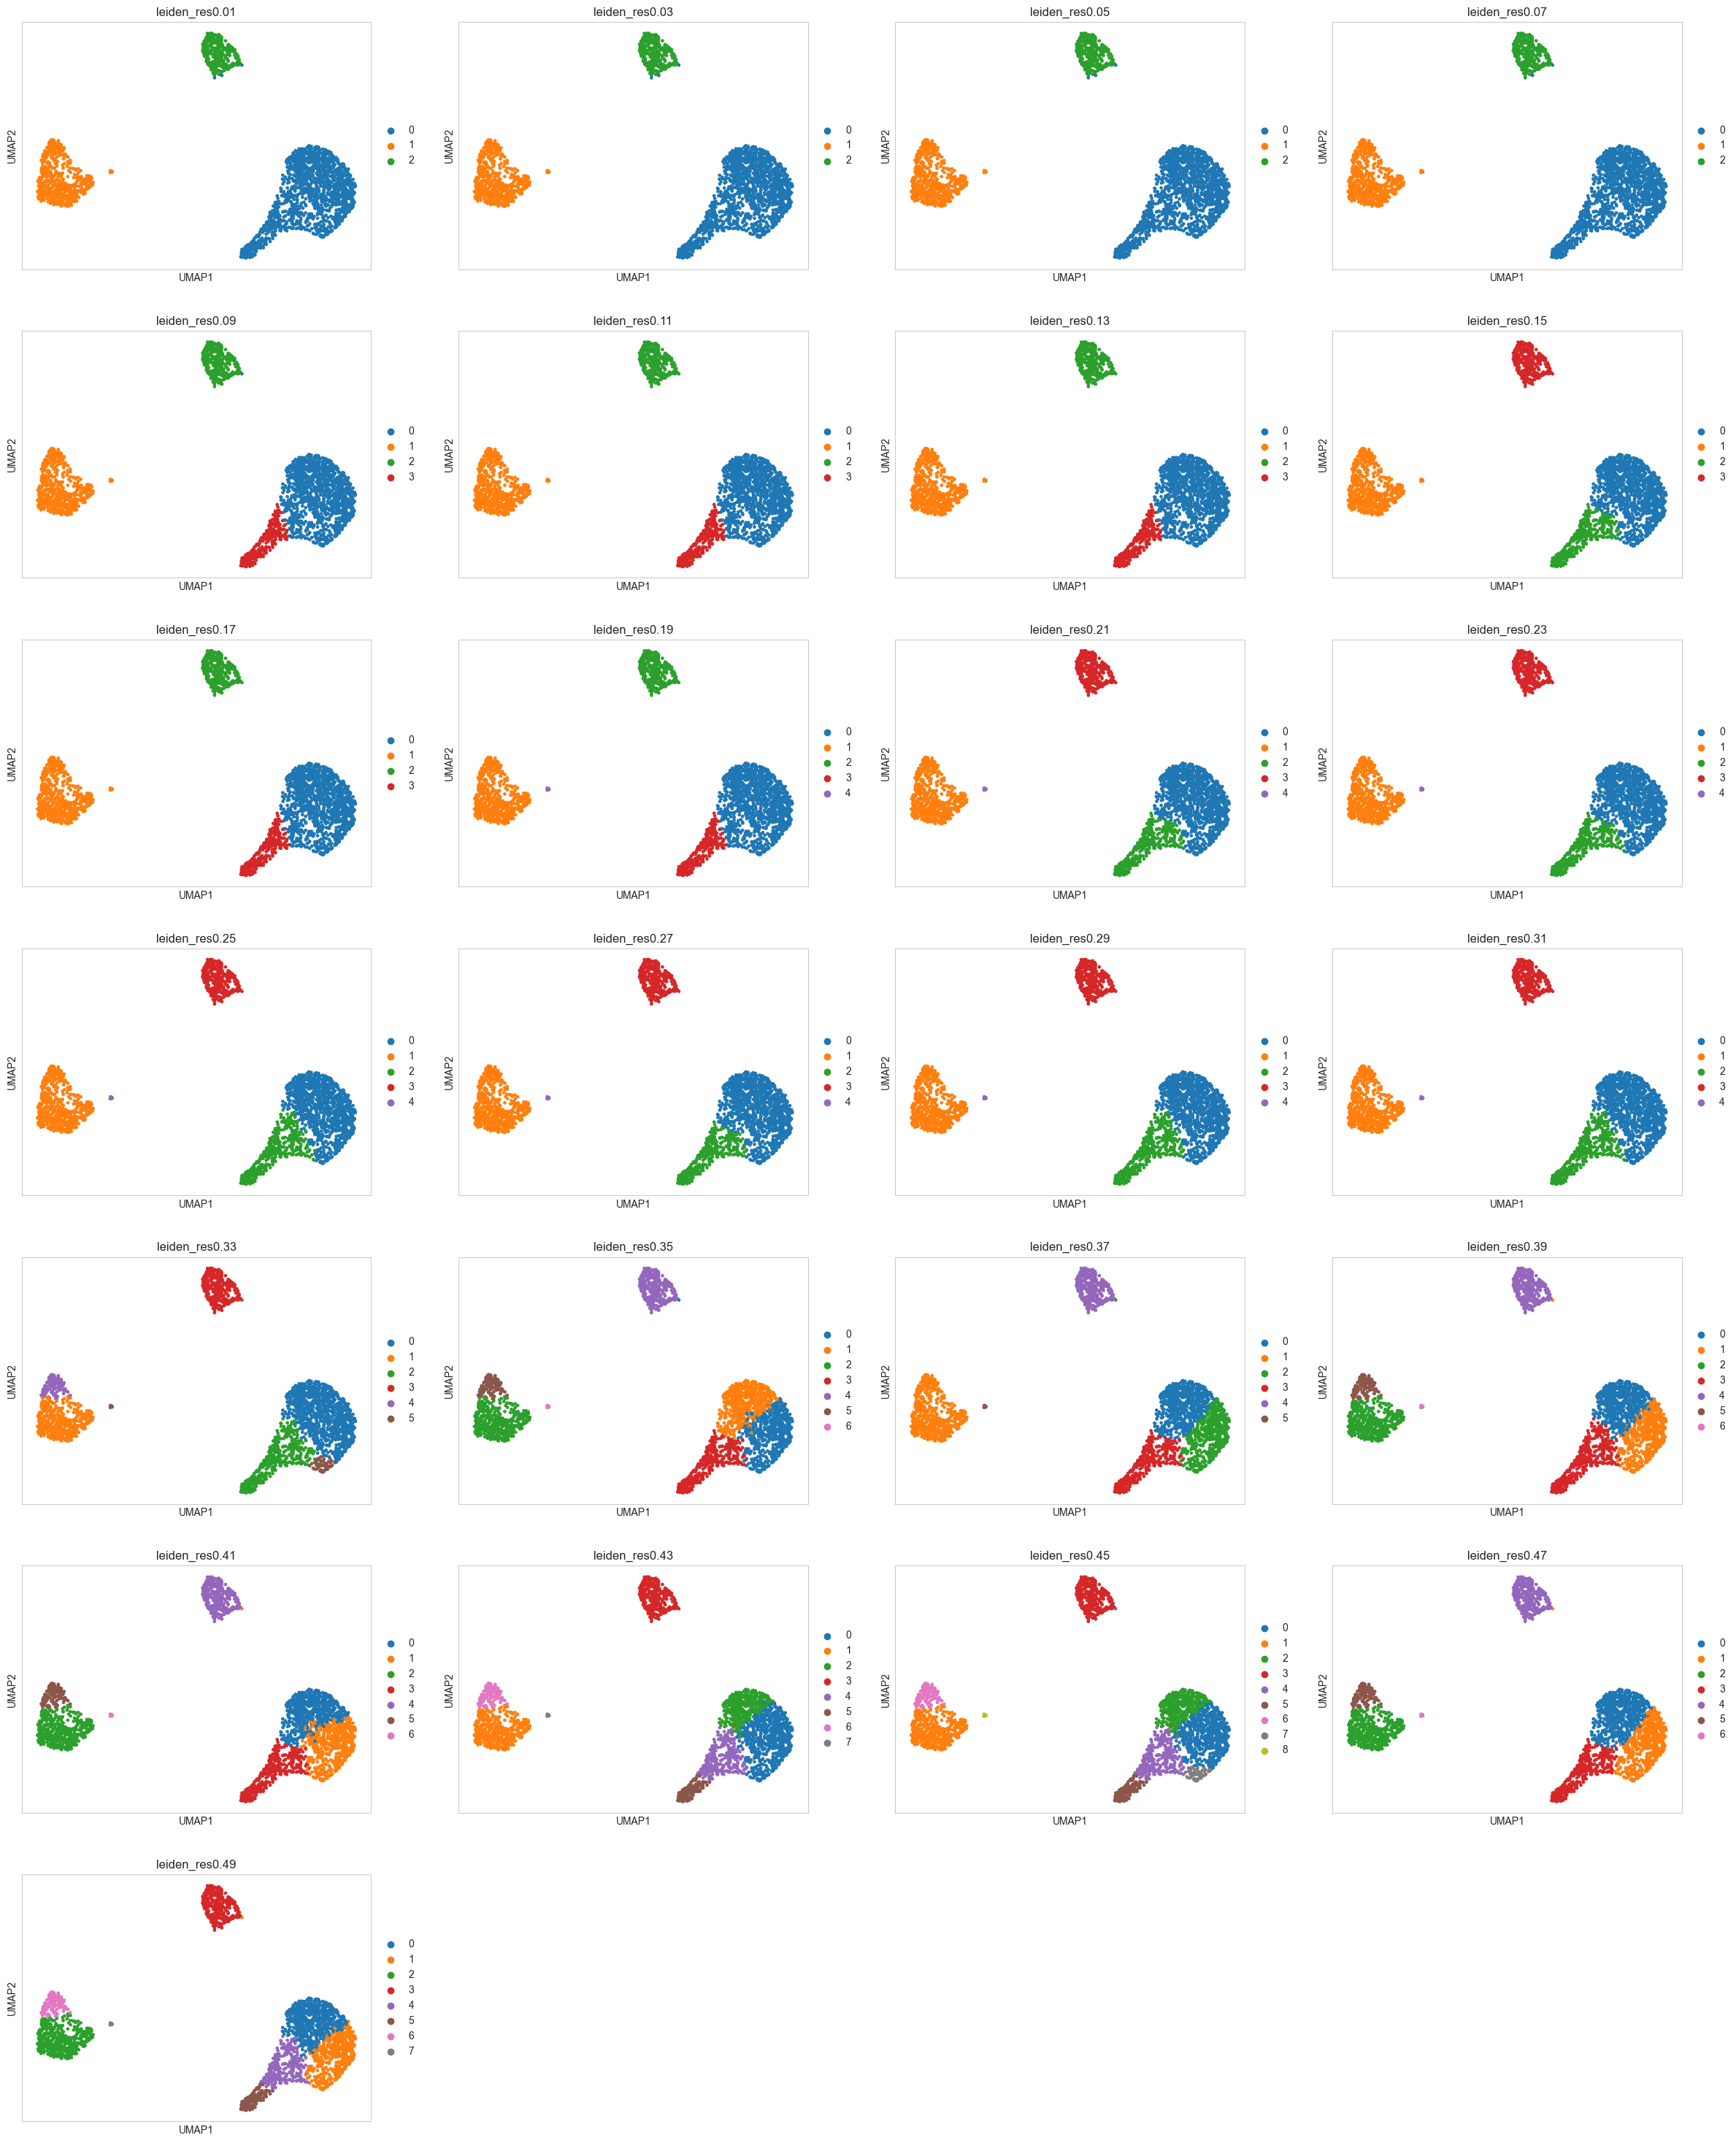

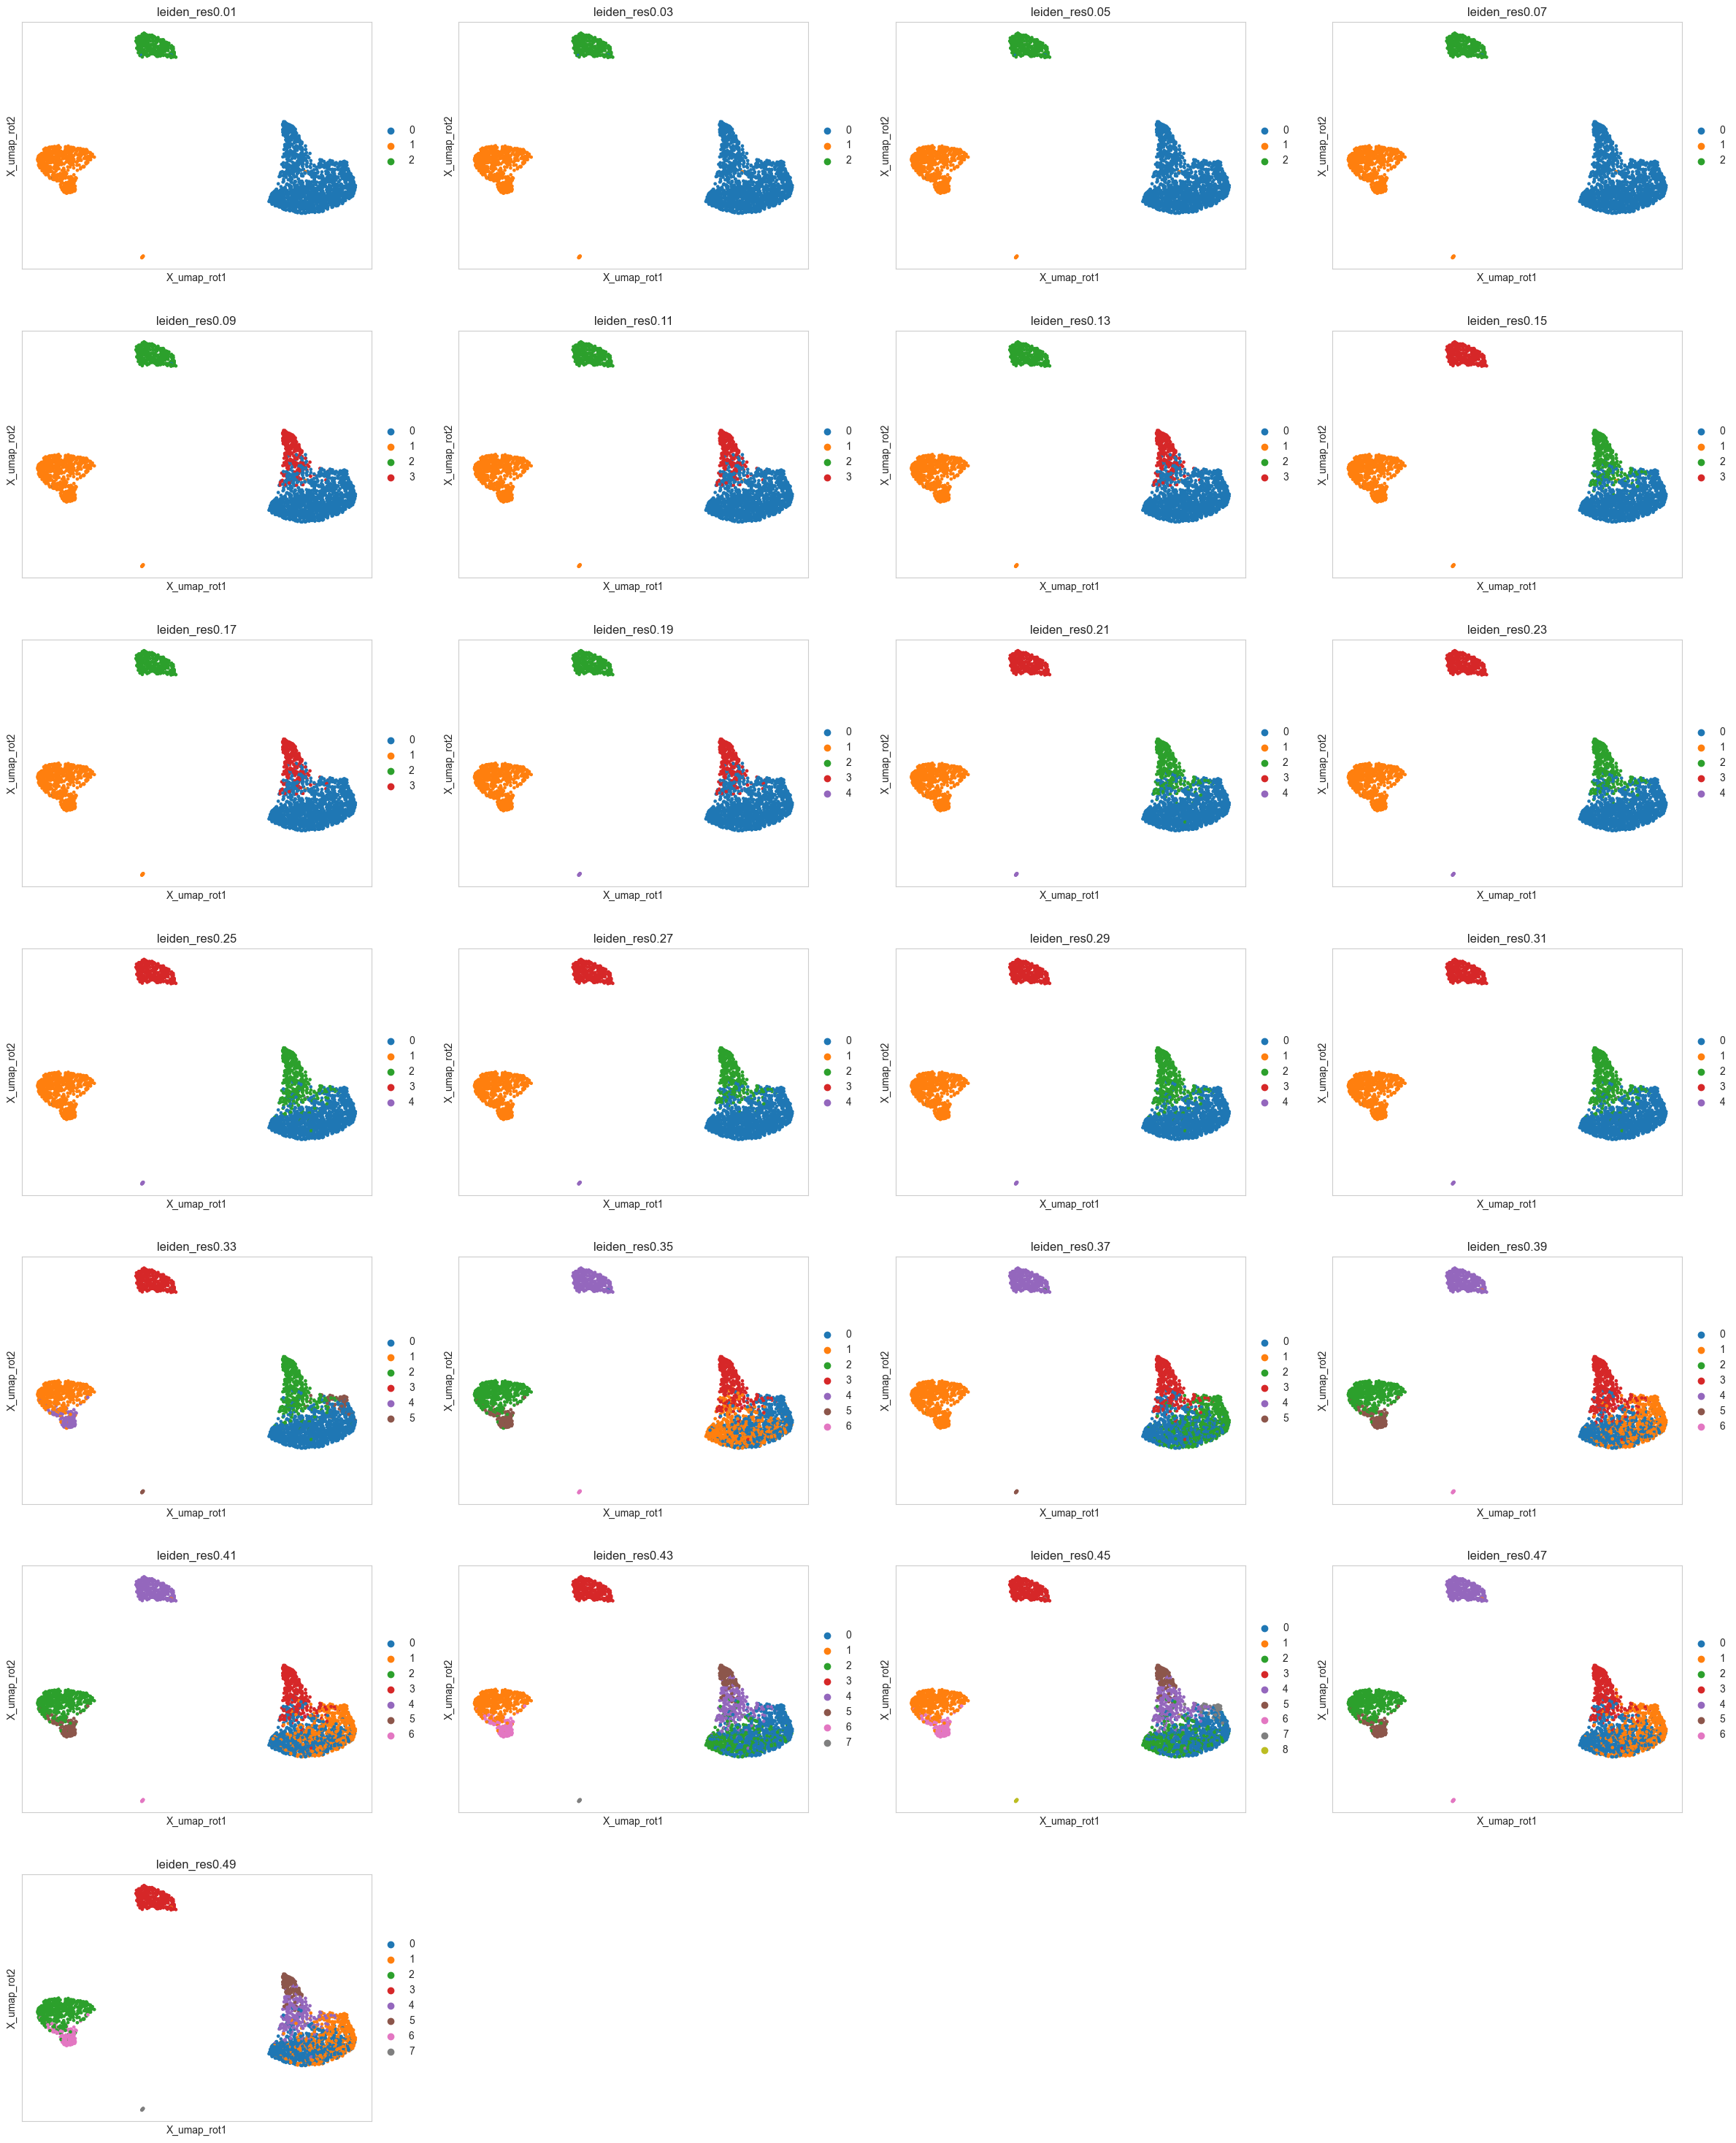

In [136]:
sc.pl.umap(data_train, color=[f"leiden_res{resolution}" for resolution in resolutions])
plt.show()

sc.pl.embedding(data_test, basis="X_umap_rot", color=[f"leiden_res{resolution}" for resolution in resolutions])
plt.show()

Modularities

In [137]:
importlib.reload(co)
mod_df, mod_df_wide, res_opt = co.find_optimal_clustering_resolution(data_train, data_test, resolutions)

print(f"Optimal resolution {res_opt}")

resolution: 0.01 - clusters: 3 - Train: 0.493 - Test: 0.492 - Random: 0.227
resolution: 0.03 - clusters: 3 - Train: 0.484 - Test: 0.482 - Random: 0.216
resolution: 0.05 - clusters: 3 - Train: 0.474 - Test: 0.473 - Random: 0.21
resolution: 0.07 - clusters: 3 - Train: 0.465 - Test: 0.464 - Random: 0.199
resolution: 0.09 - clusters: 4 - Train: 0.459 - Test: 0.445 - Random: 0.145
resolution: 0.11 - clusters: 4 - Train: 0.452 - Test: 0.438 - Random: 0.137
resolution: 0.13 - clusters: 4 - Train: 0.445 - Test: 0.431 - Random: 0.127
resolution: 0.15 - clusters: 4 - Train: 0.438 - Test: 0.422 - Random: 0.113
resolution: 0.17 - clusters: 4 - Train: 0.43 - Test: 0.416 - Random: 0.115
resolution: 0.19 - clusters: 5 - Train: 0.422 - Test: 0.408 - Random: 0.106
resolution: 0.21 - clusters: 5 - Train: 0.417 - Test: 0.401 - Random: 0.094
resolution: 0.23 - clusters: 5 - Train: 0.411 - Test: 0.394 - Random: 0.086
resolution: 0.25 - clusters: 5 - Train: 0.406 - Test: 0.389 - Random: 0.076
resolution: 0.

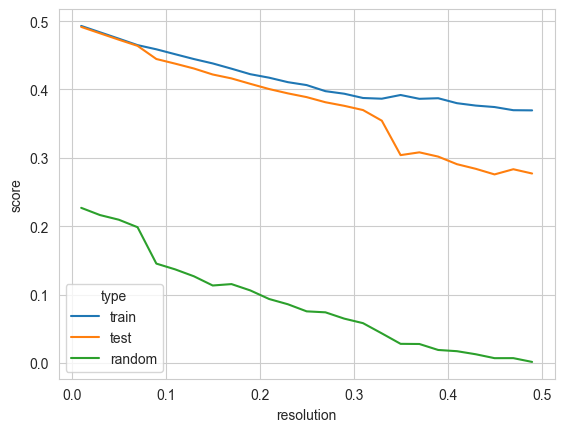

In [138]:
sns.lineplot(data=mod_df, x="resolution", y="score", hue="type")
plt.show()

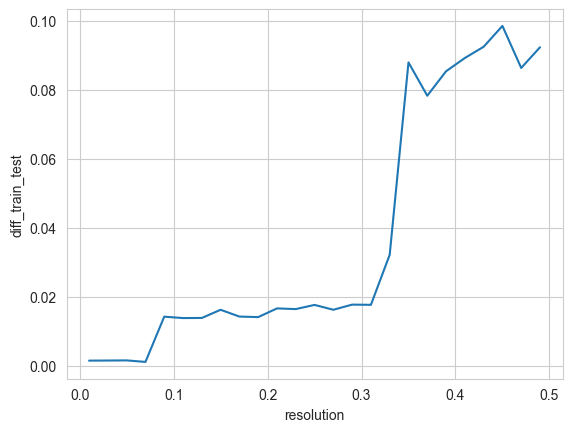

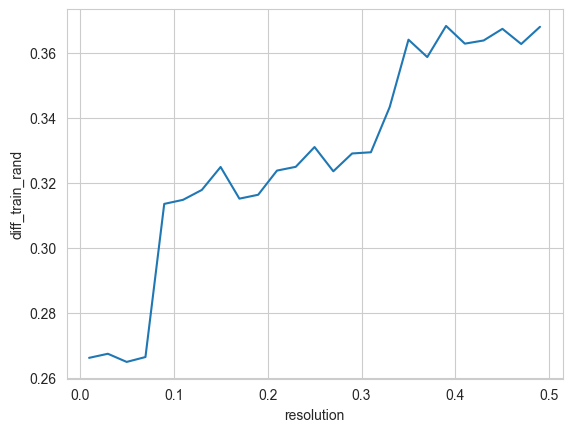

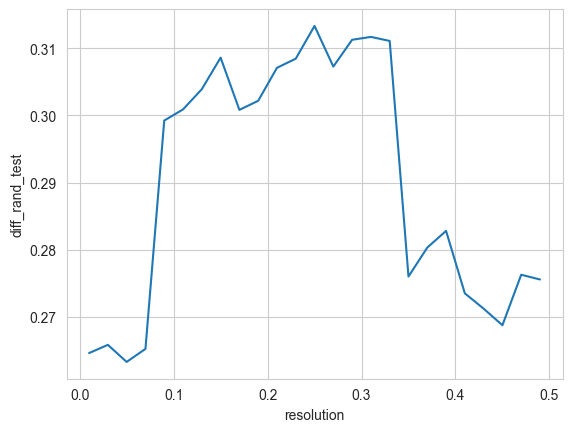

In [139]:
sns.lineplot(data=mod_df_wide, x="resolution", y="diff_train_test")
plt.show()
sns.lineplot(data=mod_df_wide, x="resolution", y="diff_train_rand")
plt.show()
sns.lineplot(data=mod_df_wide, x="resolution", y="diff_rand_test")
plt.show()

## Cluster analysis

Optimal Leiden resolution: Maximal difference between random and test

In [140]:
sc.tl.leiden(data_gene, resolution=res_opt, key_added="leiden_opt")

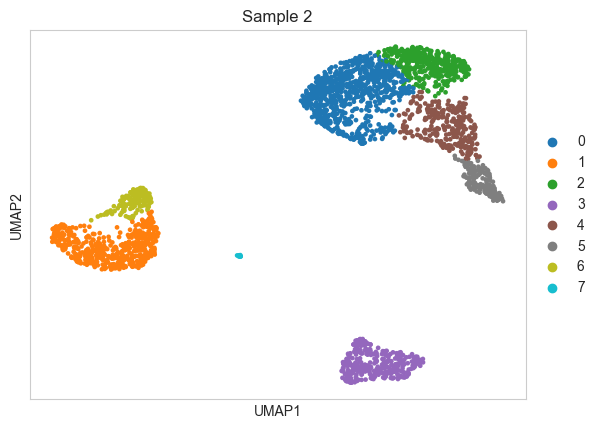

In [141]:
sc.pl.umap(data_gene, color="leiden_opt", palette="tab10", title="Sample 2")
plt.show()

In [142]:
data_gene.write(data_path + "/filtered_data_maxpool_processed.h5ad")

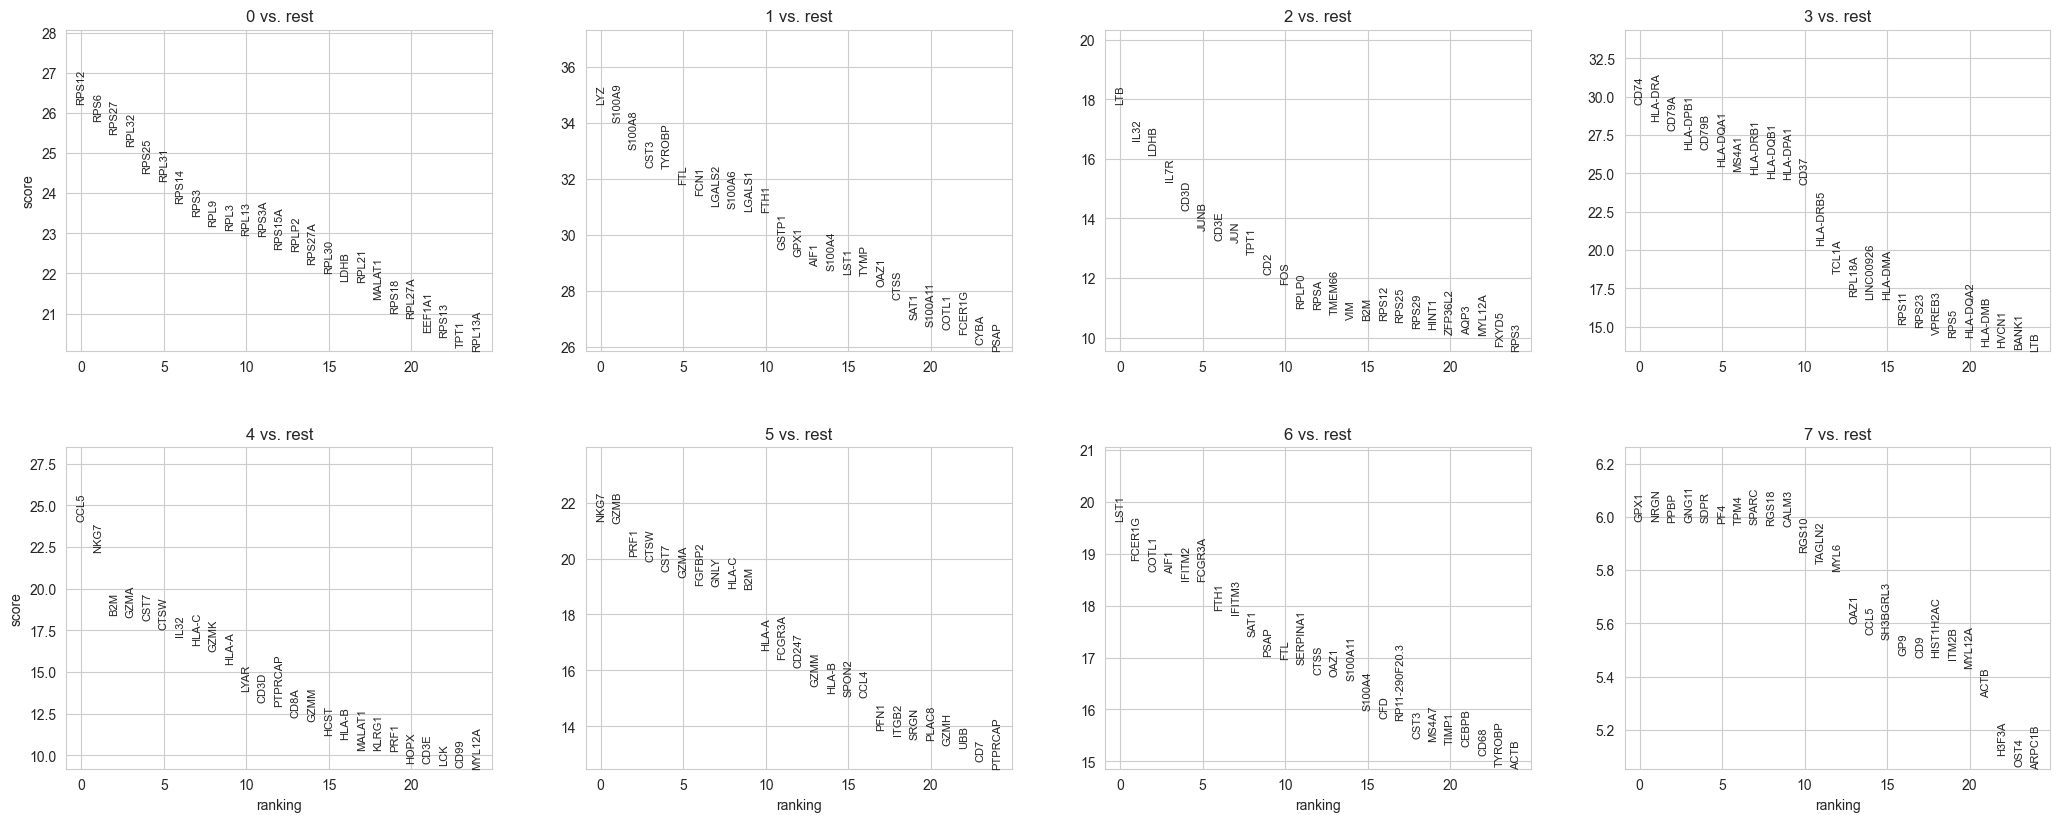

In [143]:
sc.tl.rank_genes_groups(data_gene, 'leiden_opt', method='wilcoxon')
sc.pl.rank_genes_groups(data_gene, n_genes=25, sharey=False)

In [178]:
top_genes_4 = [x[4] for x in data_gene.uns["rank_genes_groups"]["names"]]
print(top_genes_4[:25])

IndexError: invalid index (4)

In [ ]:
sc.pl.umap(data_gene, color=top_genes_4[:25], palette="tab20", cmap="viridis")